# Fitting PKS 2155-304

- Do not care if fake or real data
- We do not know anything about the models used to simulate the data
- We (of course) know the observation conditions 

In [81]:
import matplotlib.pyplot as plt

In [82]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from scipy.stats import chi2
from gammapy.catalog import SourceCatalog4FGL

from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.estimators import FluxPointsEstimator

In [83]:
#read the dataset
cta_dataset = MapDataset.read("pks2155-simulated.fits.gz", name="cta_dataset")

In [84]:
print(cta_dataset)

MapDataset
----------

  Name                            : cta_dataset 

  Total counts                    : 55626 
  Total background counts         : 53048.26
  Total excess counts             : 2577.74

  Predicted counts                : 53048.26
  Predicted background counts     : 53048.26
  Predicted excess counts         : nan

  Exposure min                    : 4.63e+07 m2 s
  Exposure max                    : 3.83e+10 m2 s

  Number of total bins            : 427500 
  Number of fit bins              : 427500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




## Data Fitting
- What is the significance of the detected source?
- Can we detect a cutoff in the observed spectrum?
- H0: Background only
- H1: Power law model
- H2: Cutoff power law

This logic can be generalised to other questions - is the source extended/variable/etc

In [85]:
#explain global Models object
models = Models()

In [86]:
## Background only
bkg_model = FoVBackgroundModel(dataset_name=cta_dataset.name)
models.append(bkg_model)
cta_dataset.models = models

In [87]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[cta_dataset])

CPU times: user 178 ms, sys: 15 ms, total: 193 ms
Wall time: 191 ms


In [88]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 23
	total stat : 200228.23

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [89]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str15,str8,str9,float64,str3,float64,float64,float64,bool,str1
cta_dataset-bkg,spectral,norm,1.0486e+00,,4.446e-03,nan,nan,False,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,


In [90]:
L0 = result.total_stat
print(L0)

200228.22734079958


### Now, add a source model

In [91]:
src_pos = SkyCoord.from_name("PKS 2155-304")

In [92]:
spectral_model = ExpCutoffPowerLawSpectralModel()
spatial_model = PointSpatialModel()
pks_model = SkyModel(spectral_model=spectral_model,
                     spatial_model=spatial_model, 
                    name="pks_model")

In [93]:
spectral_model.amplitude.value = 1e-12
spectral_model.index.value = 2.0
spectral_model.lambda_.value = 0.0
spectral_model.lambda_.frozen = True # Behaves as a power law, cutoff fixed at infty

spatial_model.lon_0.value = src_pos.ra.value
spatial_model.lat_0.value = src_pos.dec.value

In [94]:
models.append(pks_model)

In [95]:
cta_dataset.models = models

In [96]:
%%time
fit2 = Fit(optimize_opts={"print_level": 1})
result2 = fit2.run(datasets=[cta_dataset])

Position <SkyCoord (ICRS): (ra, dec) in deg
    (351.3358509, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (351.3358509, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (308.09802562, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (308.09802562, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (331.87882952, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (331.87882952, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Position <SkyCoord (ICRS): (ra, dec) in deg
    (327.555047, -30.22558907)> is outside valid IRF map range, using nearest IRF defined within
Pos

CPU times: user 12.7 s, sys: 296 ms, total: 13 s
Wall time: 13 s


In [97]:
result2

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 198
	total stat : 191086.85

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [98]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,str1
cta_dataset-bkg,spectral,norm,9.9699e-01,,4.357e-03,nan,nan,False,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
pks_model,spectral,index,2.8769e+00,,2.376e-02,nan,nan,False,
pks_model,spectral,amplitude,4.0494e-12,cm-2 s-1 TeV-1,1.459e-13,nan,nan,False,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
pks_model,spectral,lambda_,0.0000e+00,TeV-1,0.000e+00,nan,nan,True,
pks_model,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,
pks_model,spatial,lon_0,3.2971e+02,deg,1.333e-03,nan,nan,False,


In [99]:
L1 = result2.total_stat
print("del TS of detection: ", (L0-L1))

del TS of detection:  9141.376182479871


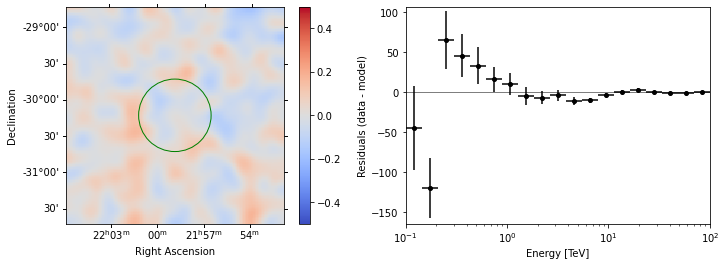

In [100]:
region = CircleSkyRegion(center=src_pos, radius=0.5*u.deg)
cta_dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

### Now, search for cutoff

In [101]:
spectral_model.lambda_.frozen = False

In [102]:
%%time
fit3 = Fit(optimize_opts={"print_level": 1})
result3 = fit3.run(datasets=[cta_dataset])

CPU times: user 3.28 s, sys: 19.3 ms, total: 3.3 s
Wall time: 3.3 s


In [103]:
result3.success

True

In [104]:
models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str15,str8,str9,float64,str14,float64,float64,float64,bool,str1
cta_dataset-bkg,spectral,norm,9.9745e-01,,4.359e-03,nan,nan,False,
cta_dataset-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
cta_dataset-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
pks_model,spectral,index,2.5503e+00,,5.365e-02,nan,nan,False,
pks_model,spectral,amplitude,7.4283e-12,cm-2 s-1 TeV-1,7.174e-13,nan,nan,False,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
pks_model,spectral,lambda_,4.3597e-01,TeV-1,7.261e-02,nan,nan,False,
pks_model,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,
pks_model,spatial,lon_0,3.2971e+02,deg,1.325e-03,nan,nan,False,


In [105]:
L2 = result3.total_stat
print("del TS of cutoff: ",(L1-L2))

del TS of cutoff:  66.36767525307368


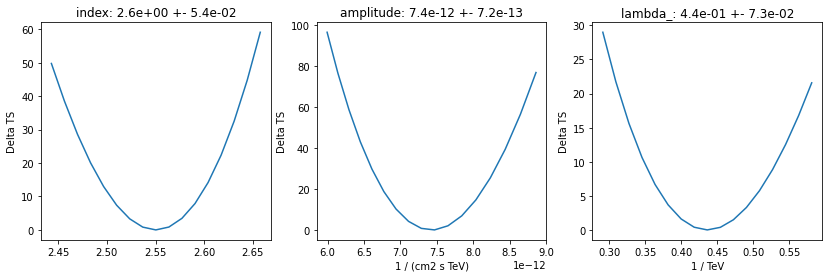

In [106]:
### See a likelihood scan of free parameters
total_stat = result3.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, pks_model.parameters.free_parameters):
    par.scan_n_values = 17

    profile = fit.stat_profile(datasets=[cta_dataset], parameter=par)
    ax.plot(profile[f"{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

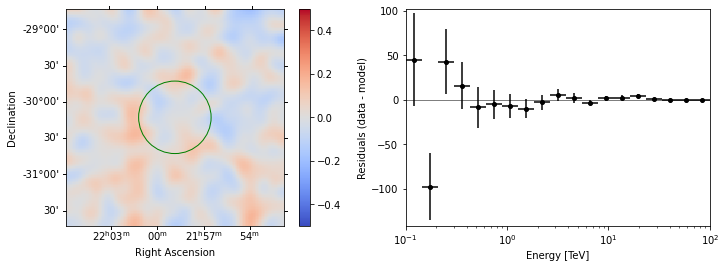

In [107]:
region = CircleSkyRegion(center=src_pos, radius=0.5*u.deg)
cta_dataset.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5),
    kwargs_spectral=dict(region=region),
);

### Get flux points

In [112]:
energy_edges = np.logspace(-1, 1, 10)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model.name)

In [113]:
%%time
flux_points = fpe.run(datasets=[cta_dataset])

CPU times: user 7.16 s, sys: 60.8 ms, total: 7.22 s
Wall time: 7.22 s


<AxesSubplot:xlabel='Energy [TeV]', ylabel='dnde (TeV / (cm2 s))'>

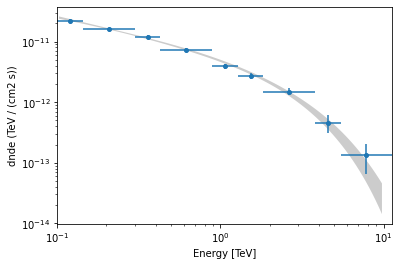

In [114]:
ax = spectral_model.plot_error(energy_bounds=[0.1,10]*u.TeV, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

We have successfully detected a cutoff in the observed spectrum.

## 2. Joint Fitting with Fermi-LAT

You can extend this
- share one EBL model among 10 blazars
- each blazar has its own intrisic model
- perform a joint fit across 10 datasets

or
- take a blazar in flare and quiescent state
- quiescent model to be shared among the two datasets
- add an extra model to the flare dataset

add your science case...

## Exercise:

Fit a joint Fermi-CTA spectra using a Logparabola and EBL model.
Note: 